In [9]:
from PIL import Image,  ImageDraw
import numpy as np
import math
import heapq
import matplotlib.pyplot as plt
import Path_planning
from Kalman import ekf
import time
from ThymioVision import ThymioVision
import Control

In [2]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [3]:
# Robot-specific constants
ROBOT_CENTER_TO_WHEEL = 47.5  # Half the wheelbase mm
ROBOT_WHEEL_RADIUS = 22    # Radius of the wheels mm
SPEED_THRESHOLD = 100         # Max Thymio wheel speed

# Normalize angle to (-pi, pi)
def normalize_angle(angle):
    return (angle + np.pi) % (2 * np.pi) - np.pi

# Astolfi Controller for Thymio
def astolfi_controller(state, goal, kr= 0.8, ka=  1.2,  goal_tolerance=20):
    #alpha doit etre plus grand que rho pour Julien 
    
    x = state[0] #en mm 
    y = state[1] #en mm 
    theta = state[2]
    x_goal, y_goal = goal
    dx = x_goal - x
    dy = y_goal - y
    rho = np.sqrt(dx**2 + dy**2)  # Distance to goal

    print ("Distance to goal = " , rho )
    alpha = normalize_angle(np.arctan2(dy, dx) - theta)
    #beta = normalize_angle(- theta - alpha)
    # Stop if the robot is close enough to the goal
    if rho < goal_tolerance:
        return 0.0, 0.0, True
    # Control laws
    v = kr * rho #kr > 0 
    #v = max(kr * rho, MIN_SPEED) 
    omega = ka * alpha 
    return v, omega, False


# Convert velocities to motor speeds
def compute_motor_speeds(v, omega):

    # Convert speed thresholds for clipping
    max_v = SPEED_THRESHOLD * 0.388  # Max linear velocity in mm/s
    max_omega = max_v / ROBOT_CENTER_TO_WHEEL  # Max angular velocity in rad/s

    v = np.clip(v, -max_v, max_v) #actul control velocity given to the thymio 
    omega = np.clip(omega, -max_omega, max_omega)

    right_wheel_mm_s = (v + omega * ROBOT_CENTER_TO_WHEEL)  # mm/s
    left_wheel_mm_s = (v - omega * ROBOT_CENTER_TO_WHEEL)  # mm/s

    thymio_speed_to_mms = 0.388
    right_wheel_enc = np.clip(right_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)
    left_wheel_enc = np.clip(left_wheel_mm_s / thymio_speed_to_mms, -SPEED_THRESHOLD, SPEED_THRESHOLD)

    # Debugging outputs
    #print(f"Clipped control inputs: v = {v}, omega = {omega}")
    #print(f"left wheel control speed = {left_wheel_enc}, right wheel control speed = {right_wheel_enc}")

    return int(left_wheel_enc), int(right_wheel_enc) , v , omega 

In [ ]:
#fonctions de Julie 
@tdmclient.notebook.sync_var 
def set_speed(right_speed,left_speed):
    global motor_right_target, motor_left_target
    motor_right_target=right_speed
    motor_left_target=left_speed

@tdmclient.notebook.sync_var
def stop_thymio():
    global motor_right_target,motor_left_target
    motor_right_target=0
    motor_left_target=0

@tdmclient.notebook.sync_var
def get_speed():
    global motor_right_speed, motor_left_speed
    return motor_right_speed,motor_left_speed

def speed_convesion(r_speed,l_speed):
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation

    #odometry 
    avg_thymio_speed = (r_speed + l_speed) / 2
    speed = avg_thymio_speed * thymio_speed_to_mms # [mm/s]
    return speed

def angular_vel_conversion(r_speed,l_speed):
    d = 95 # distance between the 2 wheels [mm]
    thymio_speed_to_mms = 0.388 # value found in covariance_estimation
    
    difference_speed = l_speed - r_speed
    omega = difference_speed * thymio_speed_to_mms / d # [rad/s]

    return omega

In [4]:
def move_to_waypoint(state, waypoint, goal_tolerance=20):
    # Astolfi controller to compute control signals
    v, omega, reached = astolfi_controller(state, waypoint, goal_tolerance=goal_tolerance)
    if reached:
        return 0, 0, True , 0 ,0
    # Convert control signals to motor speeds
    left_speed, right_speed ,v_f , omega_f = compute_motor_speeds(v, omega)
    return left_speed, right_speed, False , v_f , omega_f  #in Thymio's units 

In [5]:
@tdmclient.notebook.sync_var
def get_proximity_values():
    global prox_horizontal
    prox = prox_horizontal
    prox_front = prox[2]
    prox_left = prox[0]
    prox_left_front = prox[1]
    prox_right_front = prox[3]
    prox_right = prox[4]
    return prox_front, prox_left, prox_left_front, prox_right_front, prox_right

In [6]:
frame = ThymioVision.captureImageOnCommand(0)
map = ThymioVision.getMap(frame, verbose=True)
obstacles = map[0]
start = map[1]
end = map[2]

2024-12-02 11:44:31.533 Python[3300:103024] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
2024-12-02 11:44:31.974 Python[3300:103024] +[IMKClient subclass]: chose IMKClient_Legacy
2024-12-02 11:44:31.974 Python[3300:103024] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


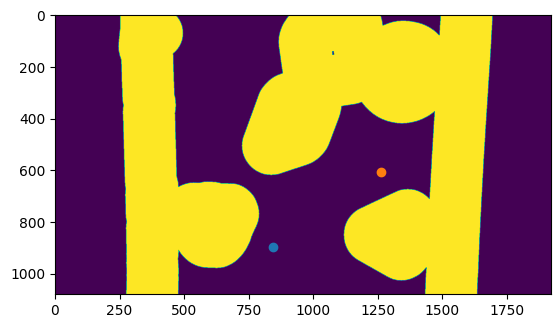

In [7]:
plt.imshow(map[0])
pose = map[1]
goal = map[2]
plt.plot([pose[0]], [pose[1]], 'o')
plt.plot([goal[0]], [goal[1]], 'o')

In [8]:
correctedStart = [start[1], start[0]]
correctedGoal = [end[1], end[0]]
path = Path_planning.A_star(obstacles, correctedStart, correctedGoal)

Path found: [[897, 843], [897, 844], [897, 845], [897, 846], [897, 847], [896, 848], [896, 849], [895, 850], [894, 851], [893, 852], [892, 853], [891, 854], [890, 855], [889, 856], [888, 857], [887, 858], [886, 859], [885, 860], [884, 861], [883, 862], [882, 863], [881, 864], [880, 865], [879, 866], [878, 867], [877, 868], [876, 869], [875, 870], [874, 871], [873, 872], [872, 873], [871, 874], [870, 875], [869, 876], [868, 877], [867, 878], [866, 879], [865, 880], [864, 881], [863, 882], [862, 883], [861, 884], [860, 885], [859, 886], [858, 887], [857, 888], [856, 889], [855, 890], [854, 891], [853, 892], [852, 893], [851, 894], [850, 895], [849, 896], [848, 897], [847, 898], [847, 899], [846, 900], [845, 901], [845, 902], [844, 903], [843, 904], [842, 905], [841, 906], [841, 907], [840, 908], [840, 909], [839, 910], [839, 911], [838, 912], [838, 913], [837, 914], [836, 915], [835, 916], [835, 917], [834, 918], [833, 919], [832, 920], [831, 921], [830, 922], [829, 923], [828, 924], [82

In [10]:
swapped = Path_planning.swap_path_coordinates(path)
waypoints = []
for point in swapped:
    x, y = ThymioVision.pixelToRealSpace(point)
    waypoints.append((x*10, y*10))
waypoints = Control.segment_path(waypoints, step=40)
len(waypoints)

12

In [ ]:
#ligne droite distance 70 mm entre waypoints
""" waypoints =  [
    (0.0, 0.0),
    (69.7, 1.6),
    (138.2, 13.1),
    (204.1, 34.2),
    (265.9, 64.3),
    (322.2, 102.5),
    (371.6, 147.6),
    (413.0, 198.3),
    (445.3, 253.3),
    (467.5, 311.2)
] """

# waypoints = [
#     (0.0, 0.0),
#     (70.0, 0.0),
#     (140.0, 0.0),
#     (210.0, 0.0),
#     (280.0, 0.0),
#     (350.0, 0.0),
#     (420.0, 0.0),
#     (490.0, 0.0),
#     (560.0, 0.0),
#     (630.0, 0.0)
# ]


# Initial state [x, y, theta]
state_est=[0,0,0,0,0] 
P_est=np.diag([0.1,0.1,0.1,0.1,0.1])
goal_tolerance = 30

obs_camera=[np.nan,np.nan,np.nan]
camera_state=False

obstSpeedGain = [4, 2, -2.5, -3, -5]  # Gains for obstacle avoidance
OBSTACLE_THRESH_LOW_FRONT = 5 # Threshold to stop avoiding
OBSTACLE_THRESH_HIGH_FRONT = 15 # Threshold to start avoiding
thymio_state = 0  # 0 = Goal tracking, 1 = Obstacle avoidance

# Logging data
trajectory = []  # To store [x, y] positions
trajectory = []  # Logs (x, y) positions
metrics_rho = []  # Logs for distance to goal
metrics_alpha = []  # Logs for angle to goal

#logging pour local nav 
left_speeds = []  # Logs left wheel speeds 
right_speeds = []  # Logs right wheel speeds
proximity_sensor_data = [] 
thymio_modes = []

time_prev = time.time()

# Start motion
for waypoint in waypoints:
    print("Goal" , waypoint)
    reached = False
    while not reached:
        actual_time = time.time()
        Ts = actual_time - time_prev
        if Ts < 0.15:
            time.sleep(0.15-Ts)
        time_prev = actual_time

        prox_front, prox_left, prox_left_front, prox_right_front, prox_right = get_proximity_values()
        proximity_values = [prox_left, prox_left_front, prox_front, prox_right_front, prox_right]
    
        # Check for obstacle state transitions
        if thymio_state == 0:
        # Switch to obstacle avoidance if an obstacle is detected
            if any((prox // 100) > OBSTACLE_THRESH_HIGH_FRONT for prox in proximity_values) :
                thymio_state = 1
        elif thymio_state == 1:
        # Switch back to goal tracking if obstacles are cleared
            if all((prox // 100) < OBSTACLE_THRESH_LOW_FRONT for prox in proximity_values):
                print("Obstacle avoided")
                thymio_state = 0
                break #to go to next waypoint
        if thymio_state == 0:
            # Goal tracking
            print("Goal tracking :", waypoint)
             # Move towards the waypoint
            # input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(state_est, waypoint, goal_tolerance)
            input_left_speed, input_right_speed, reached , v_f , omega_f  = move_to_waypoint(obs_camera, waypoint, goal_tolerance)
        else:
            # Obstacle avoidance
            print("Obstacle detected !! ")
            proximity_sensor_data.append(proximity_values) 
           
            #Baseline Speed 
            spLeft = 50 
            spRight = 50
            if (abs(prox_left_front - prox_right_front) < 20 ) : 
                if prox_left_front >= prox_right_front:
                    # More space on the right, turn right
                    print("Turning right to avoid obstacle")
                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
                elif  prox_right_front >= prox_left_front:
                    # More space on the left, turn left
                    print("Turning left to avoid obstacle")
                    spLeft -= 40  # Slow down left wheel speed
                    spRight += 40  # Boost right wheedl speed
                else: 
                    print("Turning right to avoid obstacle par defaut ")
                    spLeft += 40  # Boost left wheel speed to turn right
                    spRight -= 40  # Slow down right wheel speed
            else: 
                for i in range(5):
                    spLeft += proximity_values[i] * obstSpeedGain[i] // 100
                    spRight += proximity_values[i] * obstSpeedGain[4 - i] // 100
                    """ if ( proximity_values[i] > OBSTACLE_THRESH_HIGH): 
                        print ( "Sensor" , proximity_values[i])
                        print ("spLeft  = ",spLeft , "spRight  =" , spRight) """
            #time.sleep(0.3) 
            input_left_speed = int(spLeft)
            input_right_speed = int(spRight)
            #left_speeds.append(input_left_speed)  # Append left wheel speed
            #right_speeds.append(input_right_speed)  
            input_right_speed = np.clip(input_right_speed, -200, 200)
            input_right_speed = np.clip(input_right_speed, -200, 200)
            

        set_speed(input_right_speed, input_left_speed)
        # Get current odometry data
        r_speed_odo, l_speed_odo = get_speed()
        actual_v = speed_convesion(r_speed_odo, l_speed_odo)
        actual_w = angular_vel_conversion(r_speed_odo, l_speed_odo)
        obs_odometry = [actual_v, actual_w]

        # Control input
        input_v = v_f #Ca jsp si je remplace par actual_v et actual_w
        input_w = omega_f
        control_vect_prev = [input_v, input_w]

        # Update state with Kalman filter
        state_est, P_est = ekf(state_est, control_vect_prev, P_est, obs_camera, obs_odometry, camera_state,Ts)
        # Log trajectory
        trajectory.append((state_est[0], state_est[1]))
        thymio_modes.append(thymio_state)
        
        # Calculate and log metrics
        rho = np.sqrt((waypoint[0] - state_est[0])**2 + (waypoint[1] - state_est[1])**2)
        alpha = normalize_angle(np.arctan2(waypoint[1] - state_est[1], waypoint[0] - state_est[0]) - state_est[2])
        metrics_rho.append(rho)
        metrics_alpha.append(alpha)
       

    # Stop the robot at the waypoint
    stop_thymio()
    print(f"Reached waypoint: {waypoint}")

print("Trajectory completed!")

Goal (362.25, 605.25)
Goal tracking : (362.25, 605.25)
Distance to goal =  nan


ValueError: cannot convert float NaN to integer